In [26]:
import numpy as np
import pandas as pd
import os 
from collections import OrderedDict
import time
import deepdish.io as dd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from utils.inference import SVI
import utils.models as m
from utils.layers import *
from utils.inception import *
import utils.datasets as d

In [2]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666)

In [4]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
train = d.H_alphaSequences(X_train, y_train)
test = d.H_alphaSequences(X_test, y_test)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size=512, shuffle=True)

# ResNetVAE

In [7]:
class ResNetVAE(nn.Module):
    # version with adaptive pooling
    def __init__(self, channels, activation=nn.ReLU()):
        super(ResNetVAE, self).__init__()
        self.activation = activation
        assert len(channels)==4
        self.encoder_input = Reshape(out_shape=(1,160))
        
        self.conv0  = nn.Conv1d(in_channels=1, out_channels=channels[0], kernel_size=6, stride=2, padding=0, bias=False)
        
        # first encoder block
        self.conv1 = nn.Conv1d(in_channels=channels[0], out_channels=channels[1], kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm1d(num_features=64)

        self.conv2 =  nn.Conv1d(in_channels=channels[1], out_channels=channels[1], kernel_size=4, stride=2, padding=0, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=channels[1])

        self.residual1 = nn.Conv1d(in_channels=channels[0], out_channels=channels[1], kernel_size=4, stride=2, padding=0, bias=False)
        self.bnr1 = nn.BatchNorm1d(num_features=channels[1])
 
        # second encoder block
        self.conv3 = nn.Conv1d(in_channels=channels[1], out_channels=channels[2], kernel_size=5, stride=1, padding=2, bias=False)
        self.bn3 = nn.BatchNorm1d(num_features=channels[2])

        self.conv4 = nn.Conv1d(in_channels=channels[2], out_channels=channels[2], kernel_size=4, stride=2, padding=0, bias=False)
        self.bn4 = nn.BatchNorm1d(num_features=channels[2])
 
        self.residual2 = nn.Conv1d(in_channels=channels[1], out_channels=channels[2], kernel_size=4, stride=2, padding=0, bias=False)
        self.bnr2 = nn.BatchNorm1d(num_features=channels[2])
        
        # third encoder block
        self.conv5 = nn.Conv1d(in_channels=channels[2], out_channels=channels[3], kernel_size=5, stride=1, padding=2, bias=False)
        self.bn5 = nn.BatchNorm1d(num_features=channels[3])

        self.conv6 = nn.Conv1d(in_channels=channels[3], out_channels=channels[3], kernel_size=3, stride=2, padding=0, bias=False)
        self.bn6 = nn.BatchNorm1d(num_features=channels[3])
        
        self.residual3 = nn.Conv1d(in_channels=channels[2], out_channels=channels[3], kernel_size=3, stride=2, padding=0, bias=False)
        self.bnr3 = nn.BatchNorm1d(num_features=channels[3])
        
        # bottleneck
        self.encoder_flatten = Flatten(out_features=channels[3]*8)
        self.encoder_bottleneck = VariationalLayer(in_features=channels[3]*8, out_features=15)
        
        self.decoder_from_bn = nn.Linear(in_features=15, out_features=channels[3]*8)
        self.decoder_reshape = Reshape(out_shape=(channels[3], 8))
        
        # first decoder block
        self.bnr4 = nn.BatchNorm1d(num_features=channels[3])
        self.residual4 = nn.ConvTranspose1d(in_channels=channels[3], out_channels=channels[2], kernel_size=4, stride=2, padding=0, bias=False)

        self.conv7 = nn.ConvTranspose1d(in_channels=channels[3], out_channels=channels[3], kernel_size=4, stride=2, padding=0, bias=False)
        
        self.bn8 = nn.BatchNorm1d(num_features=channels[3])
        self.conv8 = nn.ConvTranspose1d(in_channels=channels[3], out_channels=channels[2], kernel_size=5, stride=1, padding=2, bias=False)
        
        # second decoder block
        self.bnr5 = nn.BatchNorm1d(num_features=channels[2])
        self.residual5 = nn.ConvTranspose1d(in_channels=channels[2], out_channels=channels[1], kernel_size=4, stride=2, padding=0, bias=False)

        self.conv9 = nn.ConvTranspose1d(in_channels=channels[2], out_channels=channels[2], kernel_size=4, stride=2, padding=0, bias=False)
        
        self.bn10 = nn.BatchNorm1d(num_features=channels[2])
        self.conv10 = nn.ConvTranspose1d(in_channels=channels[2], out_channels=channels[1], kernel_size=5, stride=1, padding=2, bias=False)

        # third decoder block
        self.bnr6 = nn.BatchNorm1d(num_features=channels[1])
        self.residual6 = nn.ConvTranspose1d(in_channels=channels[1], out_channels=channels[0], kernel_size=4, stride=2, padding=0, bias=False)

        self.conv11 = nn.ConvTranspose1d(in_channels=channels[1], out_channels=channels[1], kernel_size=4, stride=2, padding=0, bias=False)
        
        self.bn12 = nn.BatchNorm1d(num_features=channels[1])
        self.conv12 = nn.ConvTranspose1d(in_channels=channels[1], out_channels=channels[0], kernel_size=5, stride=1, padding=2, bias=False)
        
        self.bn13 = nn.BatchNorm1d(num_features=channels[0])
        self.decoder_outout = ConvTransposeDecoderOutput(
                                     in_channels=channels[0], 
                                     in_features=channels[0]*78, 
                                     out_features=160, 
                                     kernel_size=6, 
                                     stride=2, 
                                     padding=0, 
                                     bias=False
                                )
    
    def encoder(self, x_in):
        x = self.encoder_input(x_in)
        x = self.conv0(x)
        x = self.activation(x)
        
        x_r = self.residual1(x)
        x_r = self.bnr1(x_r)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)   
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + x_r
        x = self.activation(x) 
        
        x_r = self.residual2(x)
        x_r = self.bnr2(x_r)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = x + x_r
        x = self.activation(x)
         
        x_r = self.residual3(x)
        x_r = self.bnr3(x_r)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.activation(x)
        x = self.conv6(x) 
        x = self.bn6(x)
        x = x + x_r
        x = self.activation(x)
         
        x = self.encoder_flatten(x)
        z, mu, sigma = self.encoder_bottleneck(x)
        return z, mu, sigma
                                       
    def decoder(self, z_in):
        z = self.decoder_from_bn(z_in)
        z = self.decoder_reshape(z)
         
        z = self.bnr4(z) 
        z = self.activation(z)
        z_r = self.residual4(z)
        z = self.conv7(z)
        z = self.bn8(z)
        z = self.activation(z)
        z = self.conv8(z)
        z = z + z_r
        
        z = self.bnr5(z)
        z = self.activation(z)
        z_r = self.residual5(z)
        z = self.conv9(z) 
        z = self.bn10(z)
        z = self.activation(z)
        z = self.conv10(z)
        z = z + z_r
         
        z = self.bnr6(z)
        z = self.activation(z)
        z_r = self.residual6(z)
        z = self.conv11(z)
        z = self.bn12(z)
        z = self.activation(z)
        z = self.conv12(z)
        z = z + z_r
        
        z = self.bn13(z)
        z = self.activation(z)        
        return self.decoder_outout(z)
    
    def forward(self, x_in):
        z, mu, sigma = self.encoder(x_in)
        return self.decoder(z), mu, sigma

In [47]:
mod = ResNetVAE(channels=[32, 64, 64, 128], activation=nn.LeakyReLU())

In [48]:
optimizer = torch.optim.Adam(mod.parameters(), lr=1e-3)

In [49]:
svi = SVI(
        vae_model=mod,
        optimizer=optimizer,
        loss_function="GaussianNLL",
        scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1),
        tensorboard=True,
        model_name = "ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4}_bs-512",
        verbose=True
        )

cuda:0


In [50]:
lh = svi(epochs=200, train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [1/200], average_loss:76.2947, validation_loss:-15.7387
Epoch [2/200], average_loss:-25.7042, validation_loss:-33.0995
Epoch [3/200], average_loss:-54.5126, validation_loss:-62.6917
Epoch [4/200], average_loss:-69.7099, validation_loss:-111.7756
Epoch [5/200], average_loss:-85.1724, validation_loss:-118.3039
Epoch [6/200], average_loss:-80.1648, validation_loss:-90.2029
Epoch [7/200], average_loss:-96.1393, validation_loss:-123.1826
Epoch [8/200], average_loss:-94.4947, validation_loss:-68.4635
Epoch [9/200], average_loss:-97.1689, validation_loss:-116.4961
Epoch [10/200], average_loss:-97.3820, validation_loss:-124.8880
Epoch [11/200], average_loss:-111.2216, validation_loss:-127.1195
Epoch [12/200], average_loss:-104.4455, validation_loss:-124.1994
Epoch [13/200], average_loss:-112.6548, validation_loss:-147.4868
Epoch [14/200], average_loss:-111.8236, validation_loss:-136.6316
Epoch [15/200], average_loss:-119.0402, validation_loss:-156.3014
Epoch [16/200], average_loss:-117.2

Epoch [126/200], average_loss:-196.9601, validation_loss:-201.8142
Epoch [127/200], average_loss:-195.7070, validation_loss:-201.8163
Epoch [128/200], average_loss:-196.1647, validation_loss:-202.5560
Epoch [129/200], average_loss:-198.2350, validation_loss:-202.4162
Epoch [130/200], average_loss:-195.4758, validation_loss:-199.4749
Epoch [131/200], average_loss:-196.5541, validation_loss:-202.2687
Epoch [132/200], average_loss:-197.6145, validation_loss:-202.4849
Epoch [133/200], average_loss:-194.8390, validation_loss:-197.8015
Epoch [134/200], average_loss:-196.9853, validation_loss:-197.2455
Epoch [135/200], average_loss:-194.0836, validation_loss:-201.0214
Epoch [136/200], average_loss:-197.8814, validation_loss:-196.0905
Epoch [137/200], average_loss:-198.1477, validation_loss:-202.4768
Epoch [138/200], average_loss:-199.4294, validation_loss:-200.7611
Epoch [139/200], average_loss:-195.5199, validation_loss:-193.3615
Epoch [140/200], average_loss:-196.4986, validation_loss:-201.

In [51]:
lh = svi(epochs=range(200, 300), train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [201/300], average_loss:-222.6938, validation_loss:-228.9663
Epoch [202/300], average_loss:-224.0605, validation_loss:-224.0008
Epoch [203/300], average_loss:-222.8237, validation_loss:-224.3960
Epoch [204/300], average_loss:-223.4172, validation_loss:-228.1155
Epoch [205/300], average_loss:-225.4980, validation_loss:-231.8243
Epoch [206/300], average_loss:-228.1379, validation_loss:-231.4834
Epoch [207/300], average_loss:-220.3006, validation_loss:-220.1435
Epoch [208/300], average_loss:-224.7928, validation_loss:-221.6184
Epoch [209/300], average_loss:-225.1353, validation_loss:-231.7627
Epoch [210/300], average_loss:-226.9954, validation_loss:-229.2360
Epoch [211/300], average_loss:-224.2833, validation_loss:-231.5669
Epoch [212/300], average_loss:-226.6239, validation_loss:-231.3411
Epoch [213/300], average_loss:-226.3417, validation_loss:-229.9177
Epoch [214/300], average_loss:-228.3256, validation_loss:-234.2835
Epoch [215/300], average_loss:-228.9684, validation_loss:-229.

cuda:0


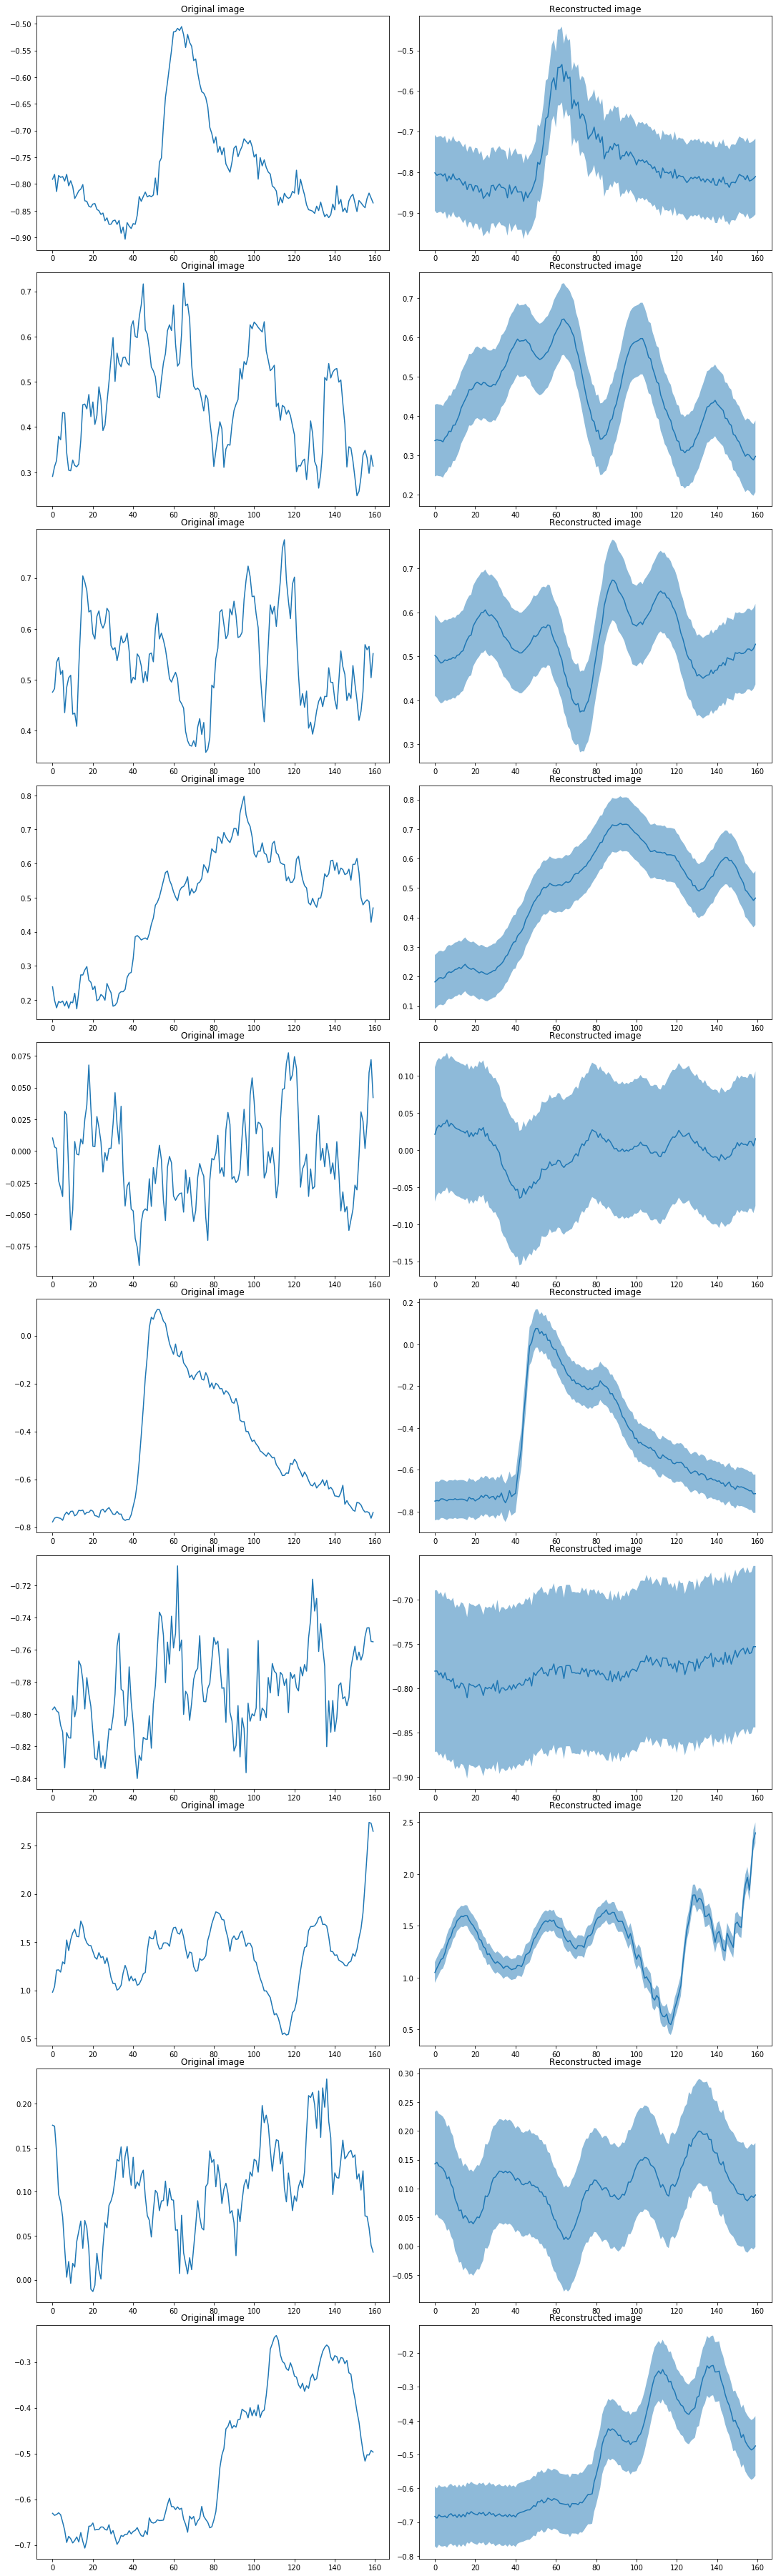

In [52]:
# epoch 300
print(svi.device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(svi.device))
#X_hat = output.cpu().detach().numpy()
mu_hat = output[0].cpu().detach().numpy()
sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    #axes[i][1].plot(X_hat[i])
    axes[i][1].plot(mu_hat[i])
    axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

In [56]:
#torch.save(svi.model, "models_and_losses/ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300.pt")
#torch.save(svi.model.state_dict(), "models_and_losses/ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300_state_dict.pt")
#torch.save(svi.optimizer, "models_and_losses/ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300_optimizer.pt")

C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNetVAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LeakyReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\ghost_000\Miniconda3\envs\Pytorch\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upo

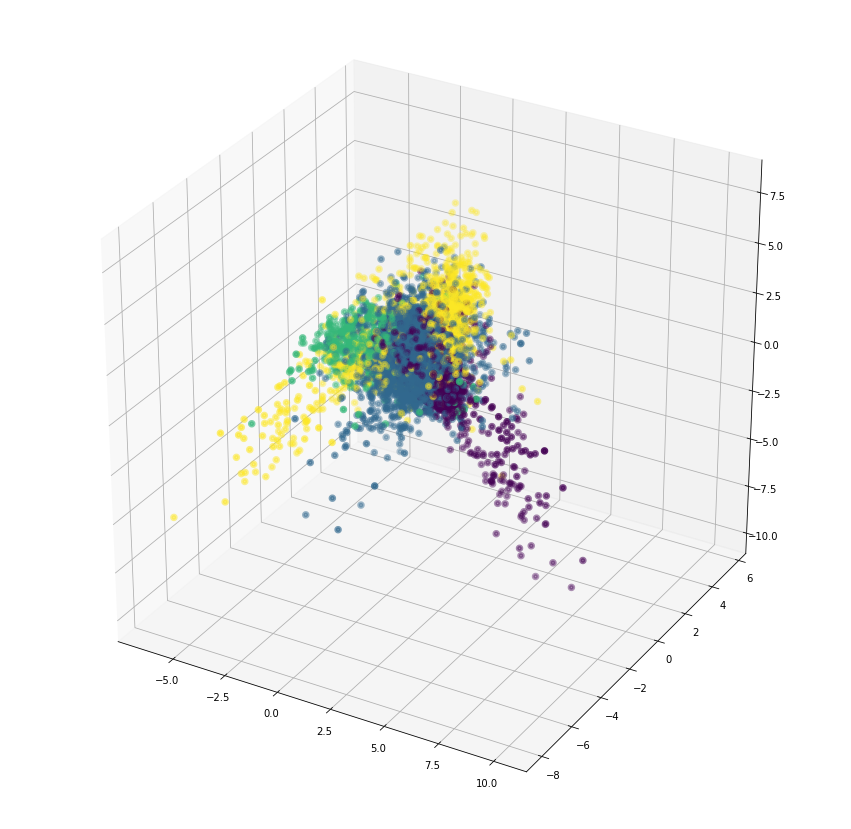

In [57]:
# epoch 300
X_1, cl = test.X, test.y
Z_hat, mu, sigma = svi.model.encoder(X_1.to(svi.device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Z_hat[:,0], Z_hat[:,1], Z_hat[:,2], c=cl, lw=3)
sc = ax.scatter(mu[:,0], mu[:,1], mu[:,2], c=cl, lw=3)

# T-SNE

In [16]:
from sklearn.manifold import TSNE

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
model = m.ResNetVAE(channels=[32,64,64,128], activation=nn.LeakyReLU())

In [11]:
model.load_state_dict(torch.load("models_and_losses/ResNetVAE_LeakyReLU_NLL_lr-{1e-3,1e-4}_bs-512_epoch-300_state_dict.pt"))

<All keys matched successfully>

In [14]:
X_1, cl = X_test, y_test
model.cuda()
Z_hat, mu, sigma = model.encoder(torch.tensor(X_1).float().to(device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

In [17]:
X_RN = TSNE(n_components=3, verbose=True).fit_transform(mu)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16736 samples in 0.036s...
[t-SNE] Computed neighbors for 16736 samples in 21.938s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16736
[t-SNE] Computed conditional probabilities for sample 2000 / 16736
[t-SNE] Computed conditional probabilities for sample 3000 / 16736
[t-SNE] Computed conditional probabilities for sample 4000 / 16736
[t-SNE] Computed conditional probabilities for sample 5000 / 16736
[t-SNE] Computed conditional probabilities for sample 6000 / 16736
[t-SNE] Computed conditional probabilities for sample 7000 / 16736
[t-SNE] Computed conditional probabilities for sample 8000 / 16736
[t-SNE] Computed conditional probabilities for sample 9000 / 16736
[t-SNE] Computed conditional probabilities for sample 10000 / 16736
[t-SNE] Computed conditional probabilities for sample 11000 / 16736
[t-SNE] Computed conditional probabilities for sample 12000 / 16736
[t-SNE] Computed conditional probabilities for sa

In [24]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

<IPython.core.display.Javascript object>


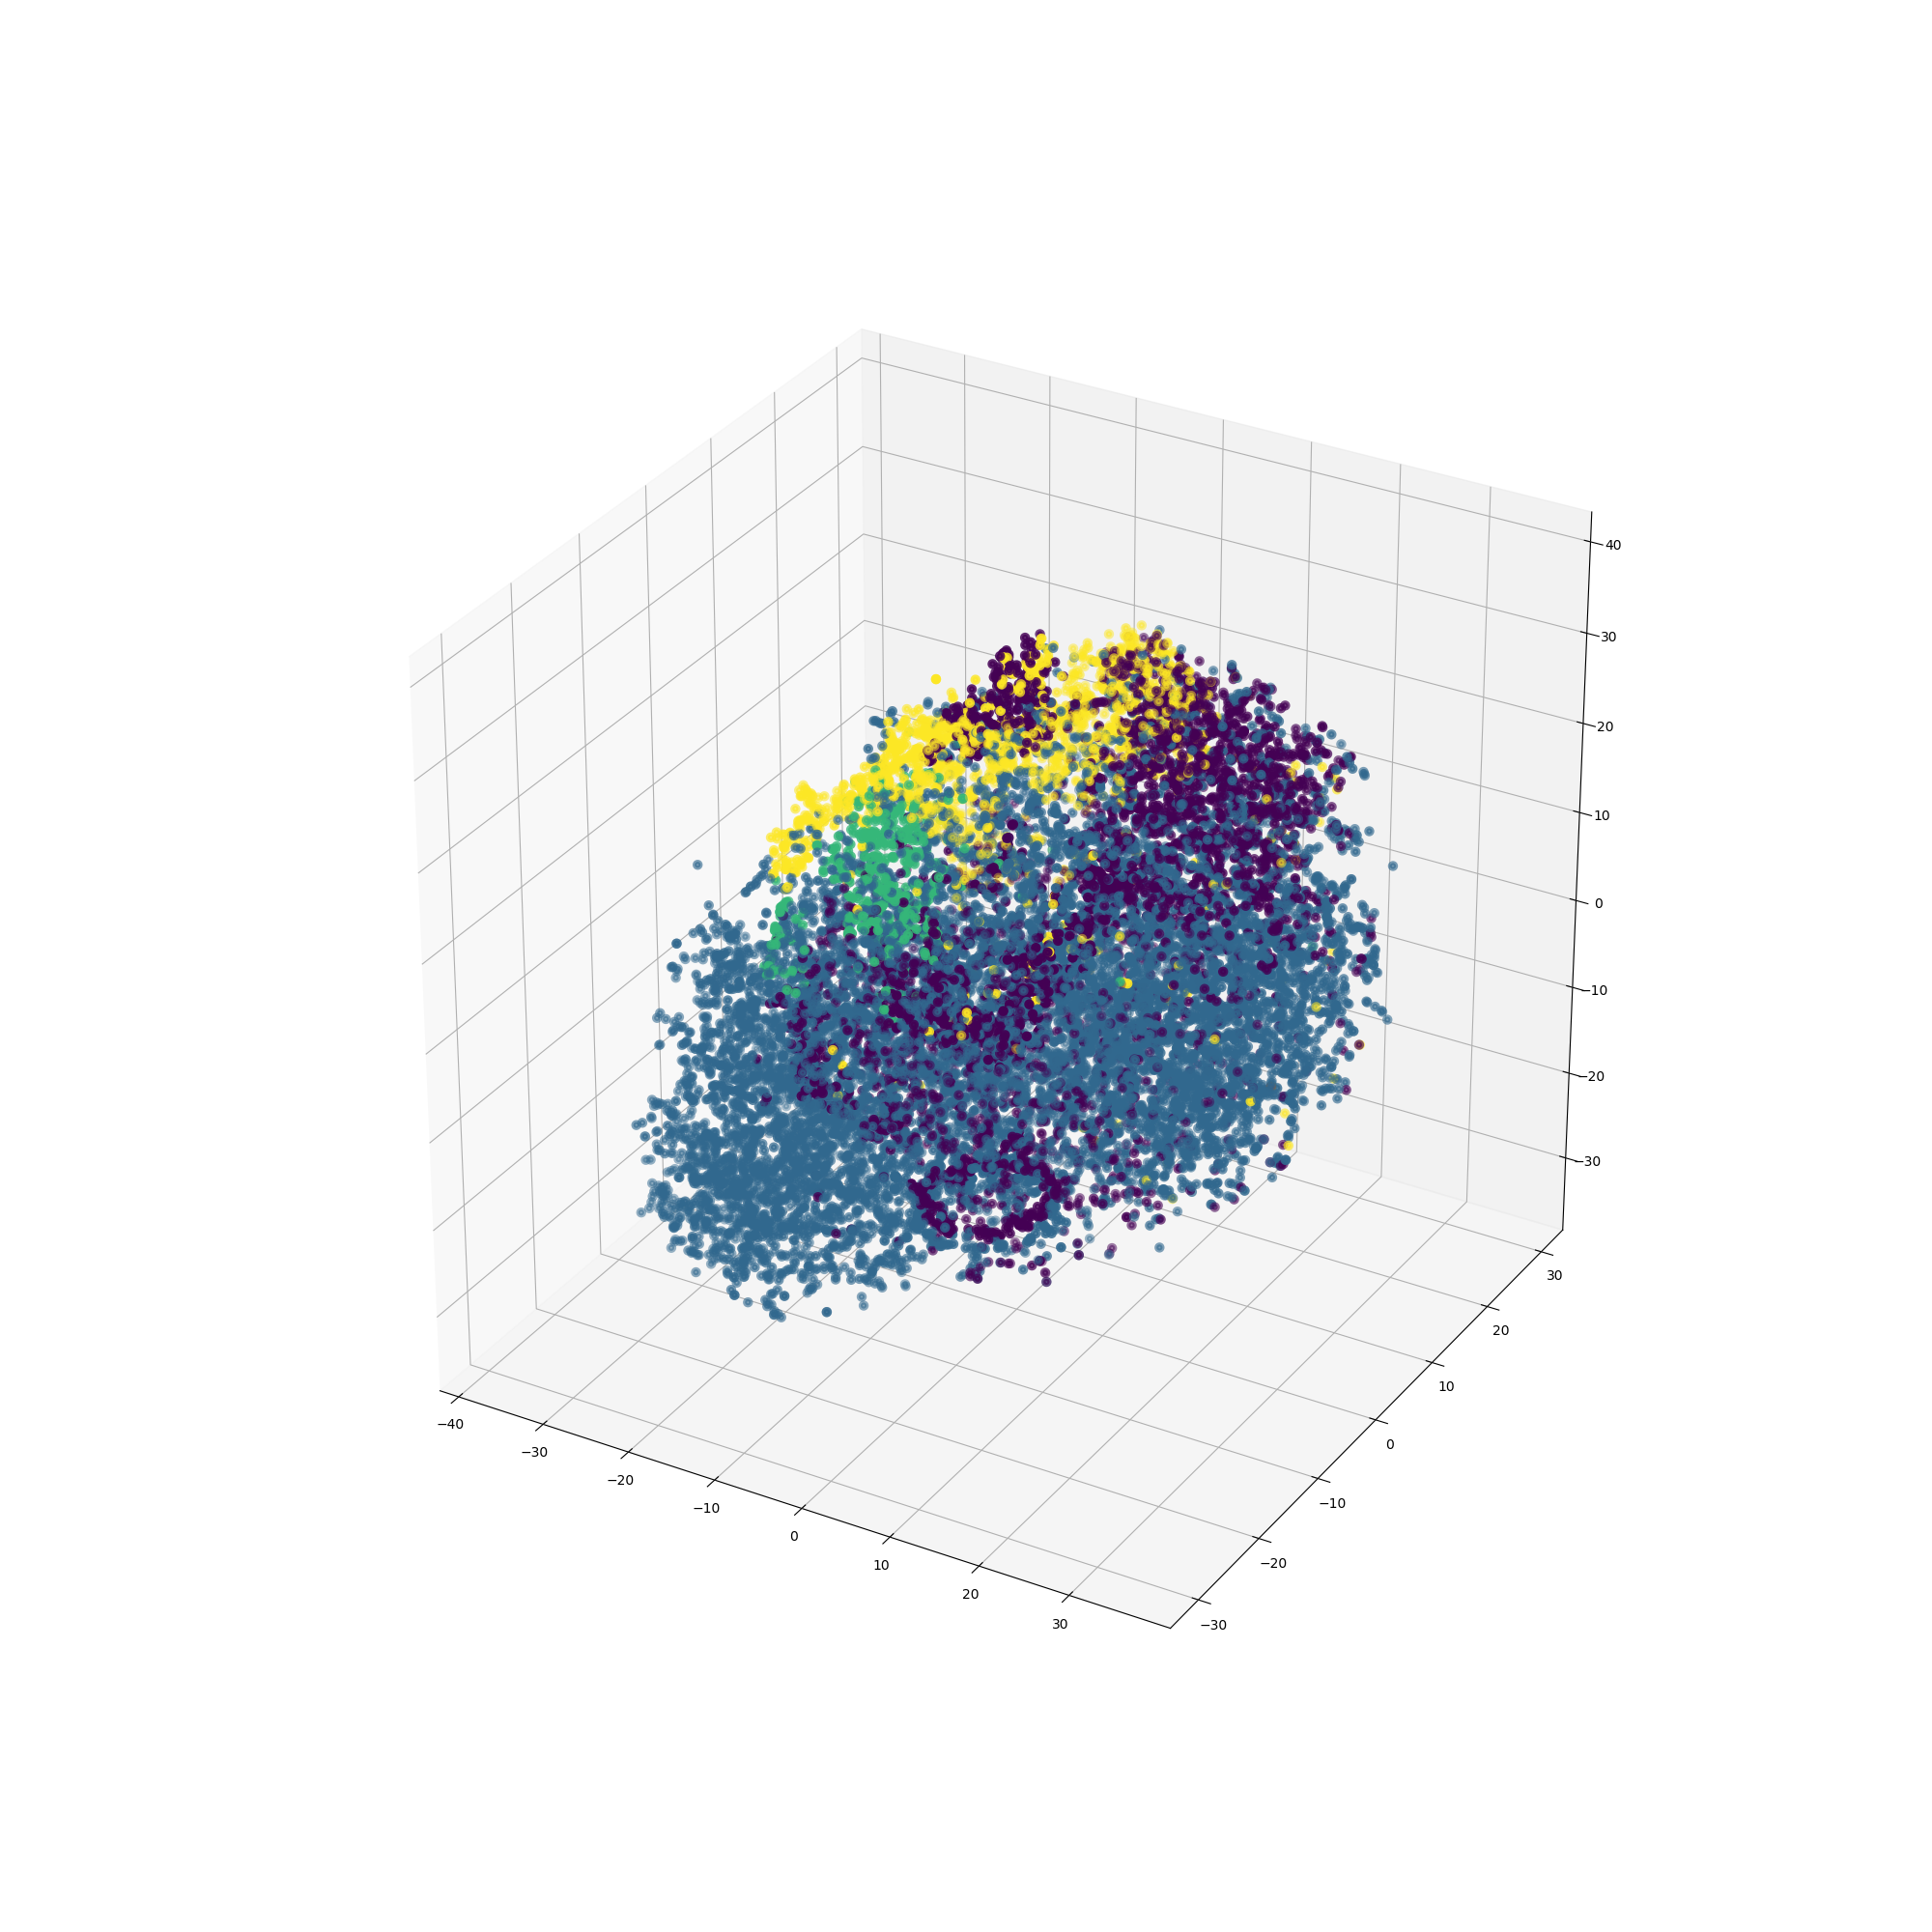

In [27]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_RN[:,1], X_RN[:,2], X_RN[:,0], c=cl, lw=3)

In [ ]:
np.save("RES")